In [1]:
import sys
import os


sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.style.use("seaborn-v0_8")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
df = pd.read_csv("../Clean_data/cleaned_weather_data.csv")

In [4]:
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])

In [ ]:
df.tail()

In [5]:

numeric_cols = [
    "temperature",
    "wind_speed",
    "wind_angle",
    "humidity",
    "pressure",
    "visibility",
]

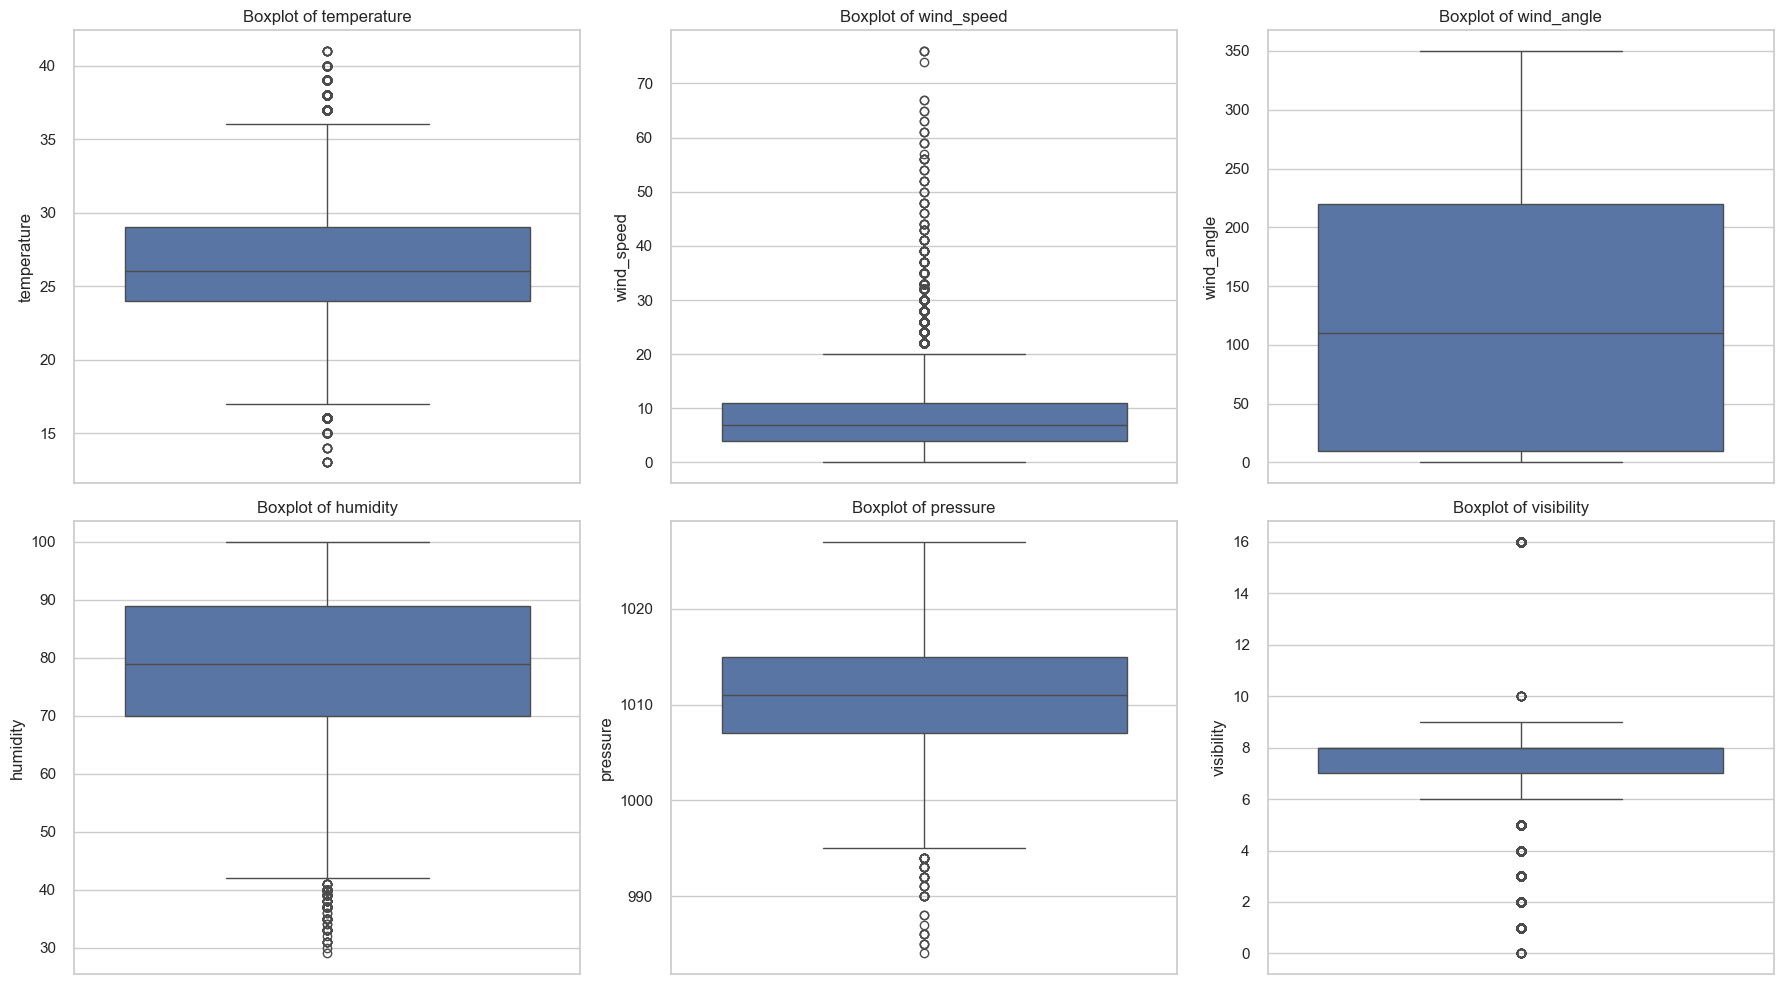

In [6]:

plt.figure(figsize=(18, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

- Temperature: Có một số outliers ở cả giới hạn trên (khoảng 37-41°C) và giới hạn dưới (khoảng 13-16°C)
- Wind speed: Có nhiều outliers ở giới hạn trên, với một số điểm dữ liệu cao bất thường (lên đến khoảng 75 km/h) so với phần lớn dữ liệu
- Pressure: Có một số outliers ở giới hạn dưới (khoảng 985-995)
- Visibility: Có vài outliers, bao gồm các giá trị cao bất thường (khoảng 10-16) và một số giá trị thấp bất thường (khoảng 0-5)
- Humidity: Có một số outliers ở giới hạn dưới (khoảng 30-40%)
- *Wind_angle*: Dữ liệu phân bố khá đều trong khoảng 0-350 độ (điều này hợp lý vì góc gió có thể nằm trong khoảng 0-360 độ)

In [ ]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Thay thế outliers bằng cận trên và cận dưới
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

cols=["temperature", "wind_speed", "humidity", "pressure", "visibility"]
for col in cols:
    df = handle_outliers(df, col)

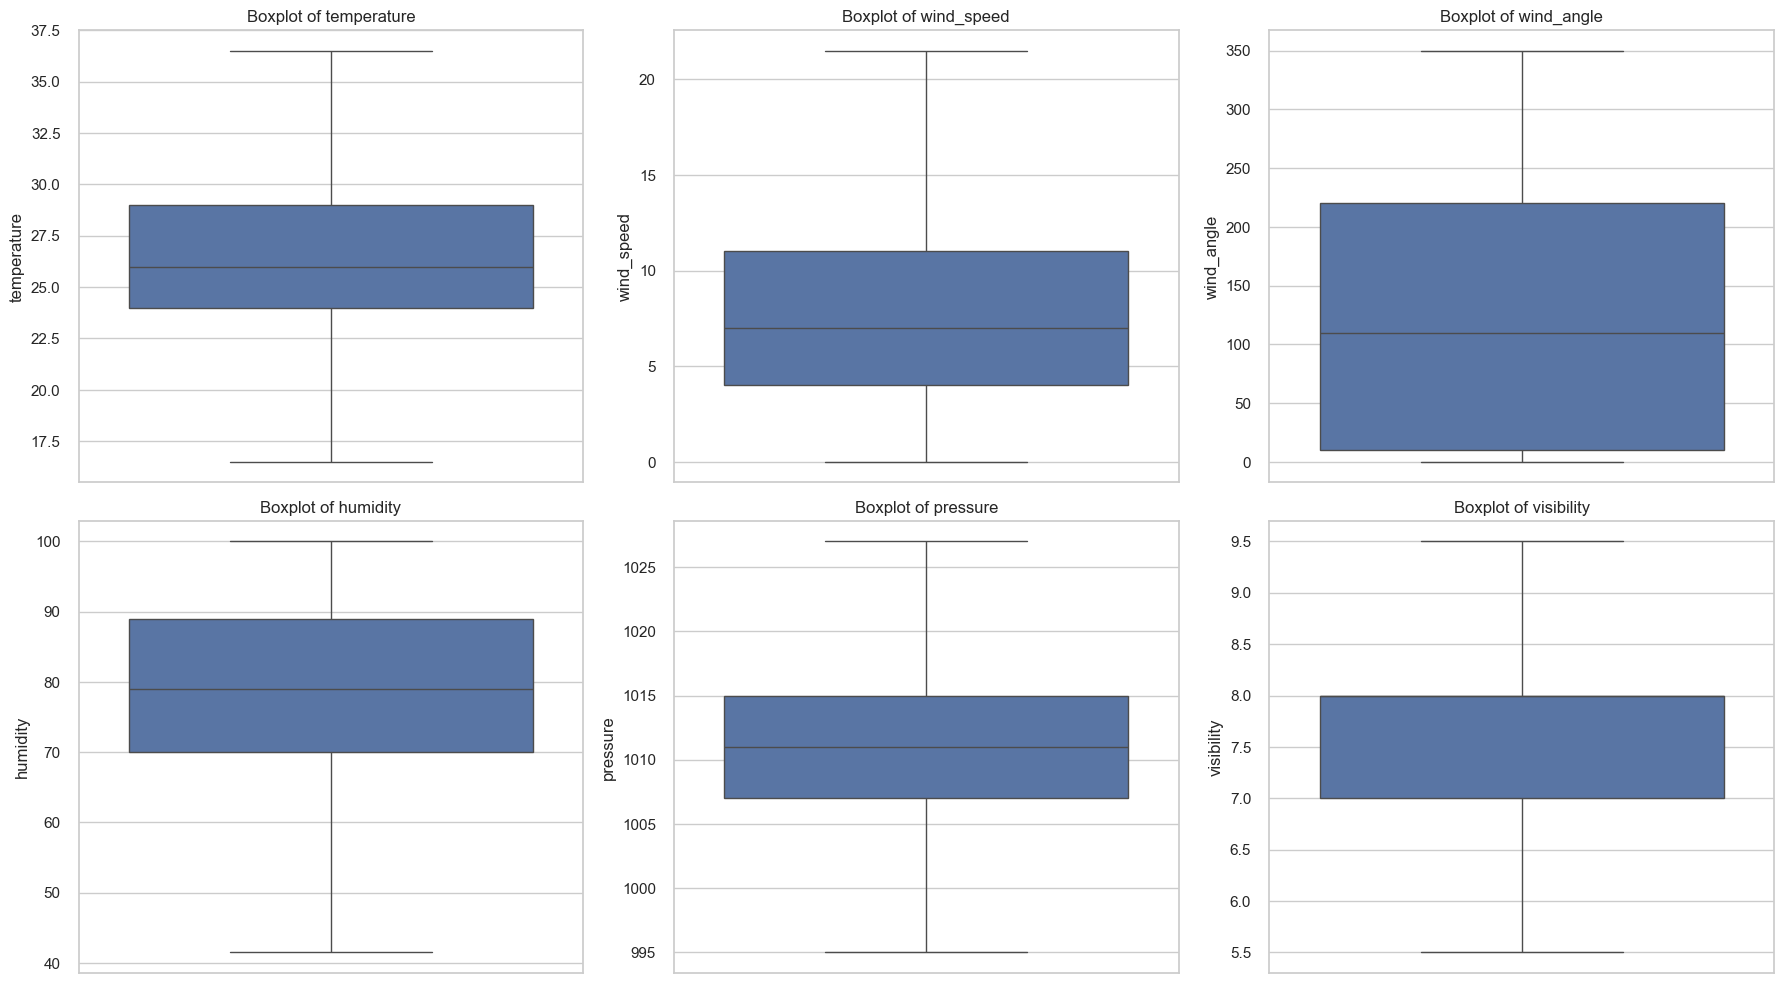

In [ ]:

plt.figure(figsize=(18, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [6]:
# Chuẩn hóa dữ liệu
features_for_clustering = (
    numeric_cols
    + ["hour","month"]
    # + [col for col in weather_encoded_df.columns if col.startswith("weather_")]
)
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(
        pd.concat([df[numeric_cols + ["hour", "month"]],], axis=1)[
            features_for_clustering
        ]
    ),
    columns=features_for_clustering,
)

In [7]:
df_scaled.head()

temperature  wind_speed  wind_angle  humidity  pressure  visibility  \
0    -0.651940    0.483839   -0.386223  0.857448  1.899959   -0.853216   
1    -0.407541    0.152609   -0.386223  0.384096  1.899959   -0.853216   
2    -0.407541    0.152609   -0.386223  0.384096  1.713334   -0.853216   
3    -0.651940    0.152609   -0.386223  0.857448  1.713334   -0.853216   
4    -0.407541   -0.344236   -0.299517  0.857448  1.713334   -0.853216   

       hour     month  
0 -1.662894 -1.505065  
1 -1.662894 -1.505065  
2 -1.518997 -1.505065  
3 -1.518997 -1.505065  
4 -1.375100 -1.505065

##### Giảm chiều dữ liệu (NGHIÊN CỨU)

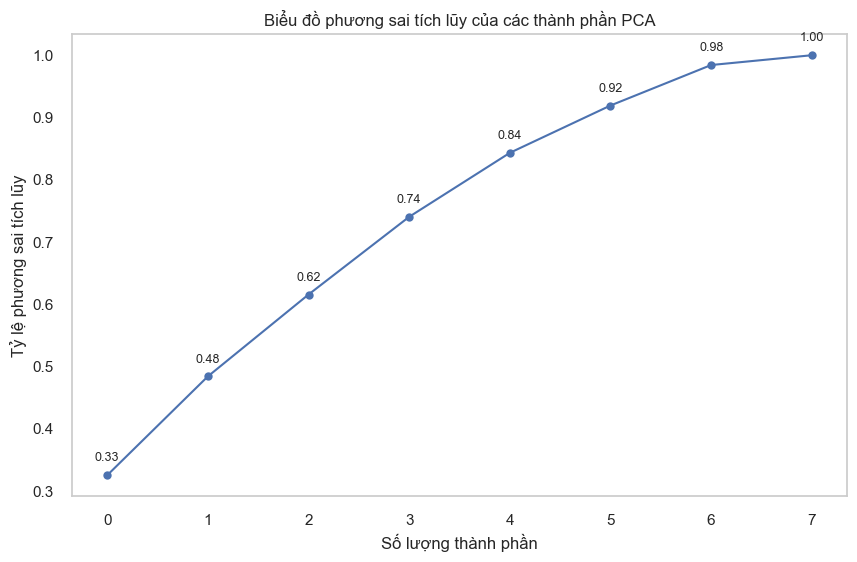

In [7]:
pca_full = PCA()
pca_full.fit(df_scaled)

# Vẽ đồ thị phương sai tích lũy
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
for i, var in enumerate(cumulative_variance):
    plt.annotate(
        f"{var:.2f}",  
        (i, var),
        textcoords="offset points",
        xytext=(0, 10),  
        ha="center",  
        fontsize=9, 
        fontweight="normal", 
    )
plt.xlabel("Số lượng thành phần")
plt.ylabel("Tỷ lệ phương sai tích lũy")
plt.title("Biểu đồ phương sai tích lũy của các thành phần PCA")
plt.grid()
plt.show()

=>***Kết luận***:
- Trực quan hóa dữ liệu : 2 Thành phần
- Cho mô hình chính xác cao:

In [8]:
pca = PCA(n_components=7)
pca_result = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_result, columns=["PC1", "PC2","PC3","PC4","PC5","PC6","PC7"])

In [9]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)  # Tính phương sai tích lũy
for i, cum_var in enumerate(cumulative_variance):
    print(f"Explained variance by P{i+1}: {explained_variance[i]:.2%}")
print(f"Total explained variance: {sum(explained_variance):.2%}")

Explained variance by P1: 32.54%
Explained variance by P2: 15.88%
Explained variance by P3: 13.15%
Explained variance by P4: 12.48%
Explained variance by P5: 10.27%
Explained variance by P6: 7.60%
Explained variance by P7: 6.50%
Total explained variance: 98.43%


Sau khi chuẩn hóa dữ liệu, áp dụng PCA (Principal Component Analysis) để giảm chiều dữ liệu từ 8 đặc trưng ban đầu xuống còn 6 thành phần chính, giữ lại 92.50% phương sai (thông tin). Trong đó, PC1 và PC2 giữ lần lượt là 32.66% và 15.82%, được sử dụng để trực quan hóa dữ liệu và kết quả phân cụm.

____


### NỘI DUNG 4: MÔ HÌNH HÓA DỮ LIỆU
#### Phần 1. Phân cụm 

Phân cụm (Clustering) là một bài toán thuộc lĩnh vực học không giám sát (unsupervised learning), trong đó mục tiêu là phân chia tập dữ liệu thành các nhóm (cụm) sao cho các điểm dữ liệu trong cùng một cụm có mức độ tương đồng cao, trong khi các cụm khác nhau thì khác biệt rõ rệt. Điểm đặc trưng của bài toán phân cụm là không yêu cầu trước các nhãn (label) cho từng mẫu dữ liệu, mà thuật toán phải tự khám phá ra cấu trúc ẩn bên trong dữ liệu dựa trên đặc trưng đầu vào.

Do không có nhãn để mô hình học từ đó, nên việc phân chia dữ liệu thành tập huấn luyện (train) và kiểm tra (test) như trong học có giám sát không có ý nghĩa rõ ràng. Cụ thể, không có một “giá trị đúng” để mô hình học hoặc kiểm định độ chính xác trên tập kiểm tra. Thay vào đó, mô hình phân cụm thường được huấn luyện và đánh giá trên toàn bộ dữ liệu bằng các tiêu chí nội tại (intrinsic metrics) 

#### A. Mô hình Kmeans

##### 1. Cơ sở lý thuyết:
 K-means là thuật toán phân cụm phân hoạch dựa trên khoảng cách Euclidean, phân chia dữ liệu thành K cụm, mỗi điểm dữ liệu thuộc về cụm có tâm gần nhất. Thuật toán cố gắng tối thiểu hóa tổng bình phương khoảng cách từ mỗi điểm đến tâm cụm gần nhất.

##### 2. Siêu tham số chính:
- n_clusters: Số lượng cụm (K) cần phân chia
- n_init: Số lần chạy thuật toán với các khởi tạo trung tâm cụm khác nhau

##### 3. Lựa chọn siêu tham số cho mô hình
Xác định số lượng cụm tối ưu

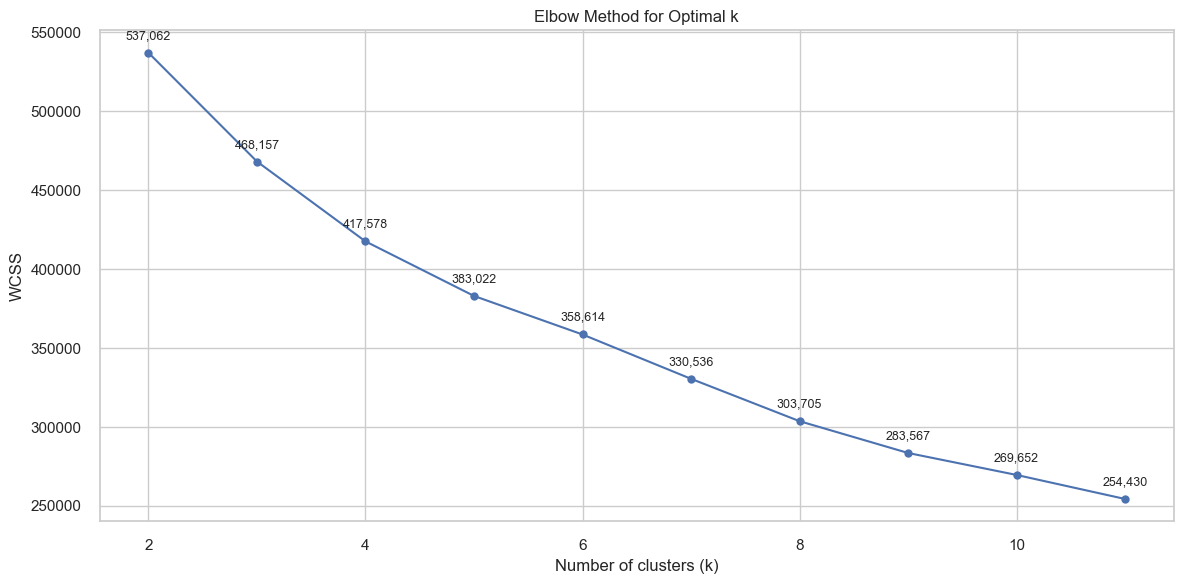

In [11]:
# Phương pháp Elbow để xác định số cụm tối ưu
wcss = []
k_range = range(2, 12, 1) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)

    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_range, wcss, marker="o", linestyle="-")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)

for i, val in enumerate(wcss):
    plt.annotate(
        f"{int(val):,}",
        (k_range[i], wcss[i]),
        textcoords="offset points",
        xytext=(0, 10), 
        ha="center",  
        fontsize=9,
    )
plt.tight_layout()
plt.show()

- Chú thích: Giá trị WCSS (Within-Cluster Sum of Squares) - tổng bình phương khoảng cách từ mỗi điểm đến tâm cụm của nó
- Xác định số cụm tối ưu: Phương pháp Elbow, số cụm tối ưu được xác định tại điểm mà đường cong "gãy khúc" rõ rệt - nơi mà việc tăng thêm số cụm không còn cải thiện WCSS đáng kể.


Tham số tối ưu n_clusters= 5 

##### 4. Huấn luyện K-means

In [12]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df_pca)

In [13]:
import pickle
import joblib
from pathlib import Path

Path("models").mkdir(exist_ok=True)
with open("models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

##### 5. Trực quan hóa kết quả K-means
*Phân phối số lượng mẫu trong từng cụm

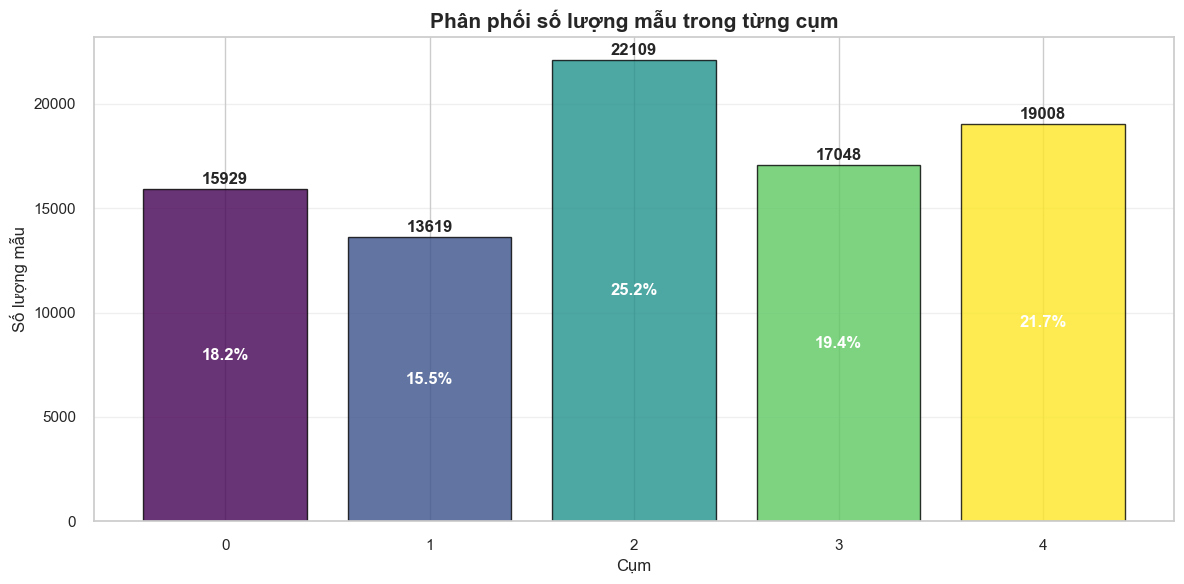

In [ ]:
plt.figure(figsize=(12, 6))
cluster_counts = df["cluster"].value_counts().sort_index()

total_samples = cluster_counts.sum()

colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
bars = plt.bar(
    cluster_counts.index,
    cluster_counts.values,
    color=colors,
    alpha=0.8,
    edgecolor="black",
)

for bar in bars:
    height = bar.get_height()
    percent = 100 * height / total_samples
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 100,  
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height / 2, 
        f"{percent:.1f}%",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",  
    )

plt.title("Phân phối số lượng mẫu trong từng cụm", fontsize=15, fontweight="bold")
plt.xlabel("Cụm", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(range(optimal_k))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Nhận xét:

*Trực quan hóa cụm trên không gian PCA

Text(0, 0.5, 'PC2 (15.88% phương sai)')

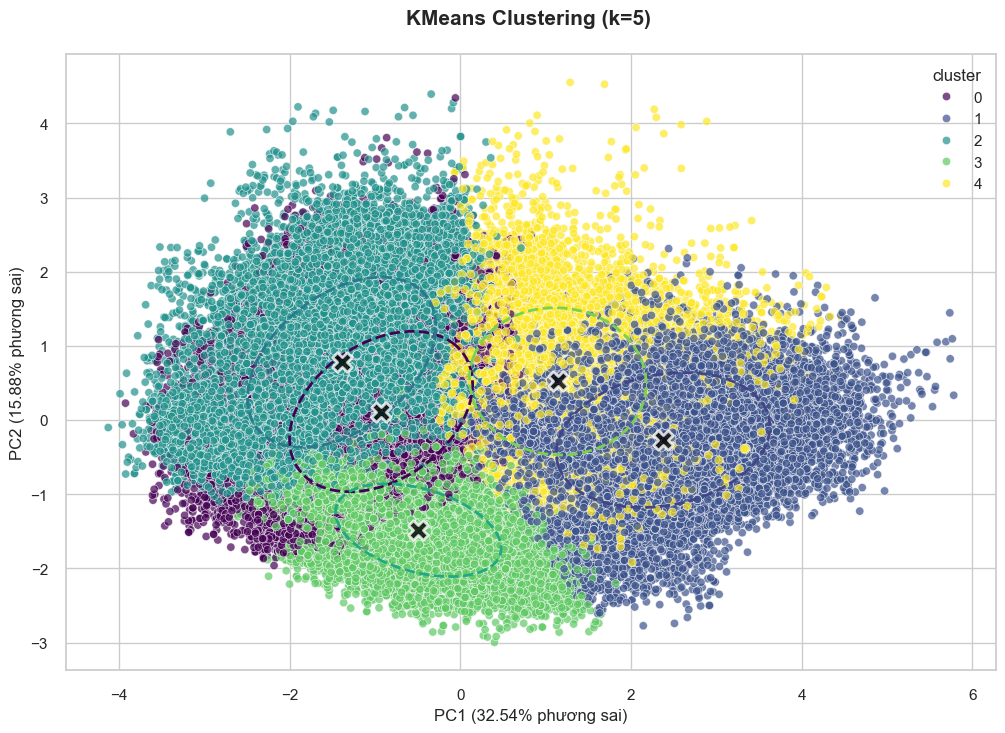

In [ ]:
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="cluster",
    data=pd.concat([df_pca, df[["cluster"]]], axis=1),
    palette="viridis",
    alpha=0.7, 
    # s=20,  
)

plt.title(
    f"KMeans Clustering (k={optimal_k}) \n",
    fontsize=15,
    fontweight="bold",
)
plt.xlabel("Thành phần chính 1 (PC1)", fontsize=12)
plt.ylabel("Thành phần chính 2 (PC2)", fontsize=12)
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f"PC1 ({explained_variance[0]:.2%} phương sai)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2%} phương sai)", fontsize=12)

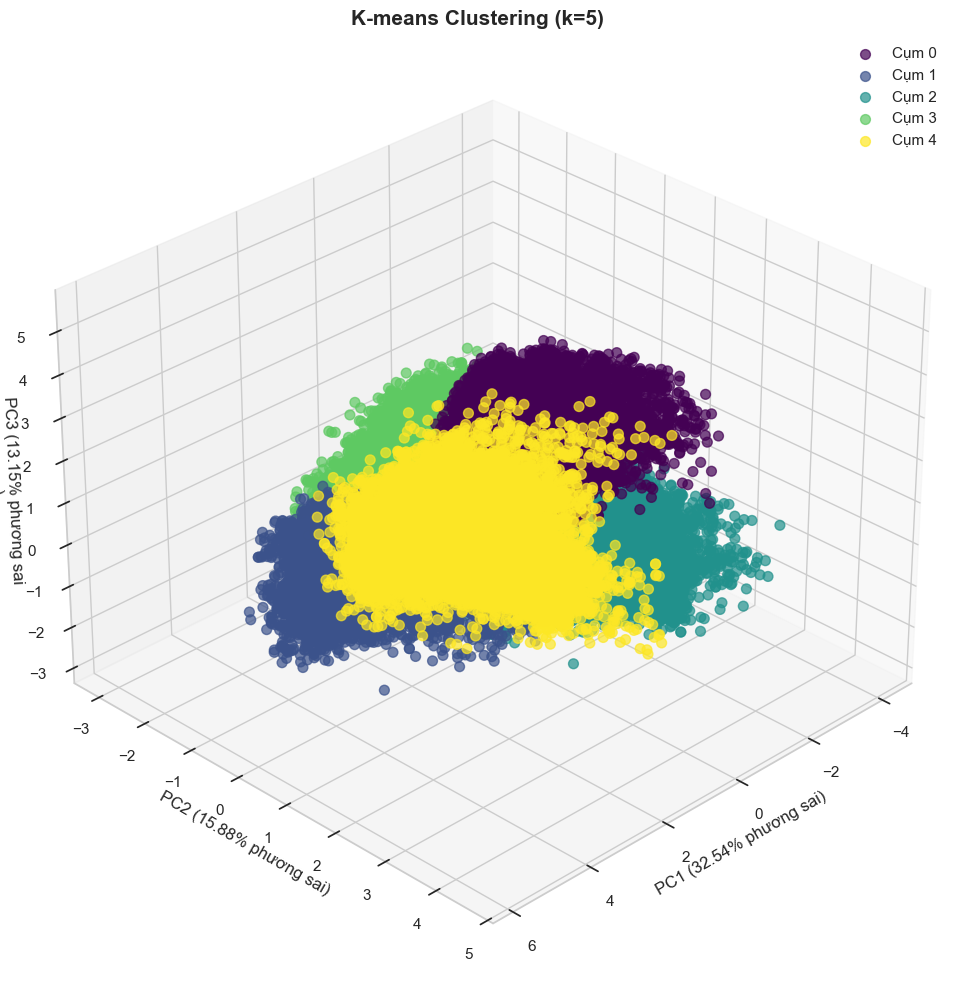

In [47]:
# Biểu đồ 3D cho phân cụm K-means
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
for cluster_idx in range(optimal_k):
    cluster_data = pd.concat([df_pca, df[["cluster"]]], axis=1)[
        df["cluster"] == cluster_idx
    ]

    ax.scatter(
        cluster_data["PC1"],
        cluster_data["PC2"],
        cluster_data["PC3"],  
        c=[colors[cluster_idx]],
        s=50,
        alpha=0.7,
        label=f"Cụm {cluster_idx}",
    )
ax.set_title(
    f"K-means Clustering (k={optimal_k}) ", fontsize=15, fontweight="bold"
)
ax.set_xlabel(f"PC1 ({explained_variance[0]:.2%} phương sai)", fontsize=12)
ax.set_ylabel(f"PC2 ({explained_variance[1]:.2%} phương sai)", fontsize=12)
ax.set_zlabel(f"PC3 ({explained_variance[2]:.2%} phương sai\n)", fontsize=12)
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

##### 6. Phân tích đặc điểm cụm và áp dụng domain knowledge

Phân bố cụm theo tháng

<Figure size 1400x800 with 0 Axes>

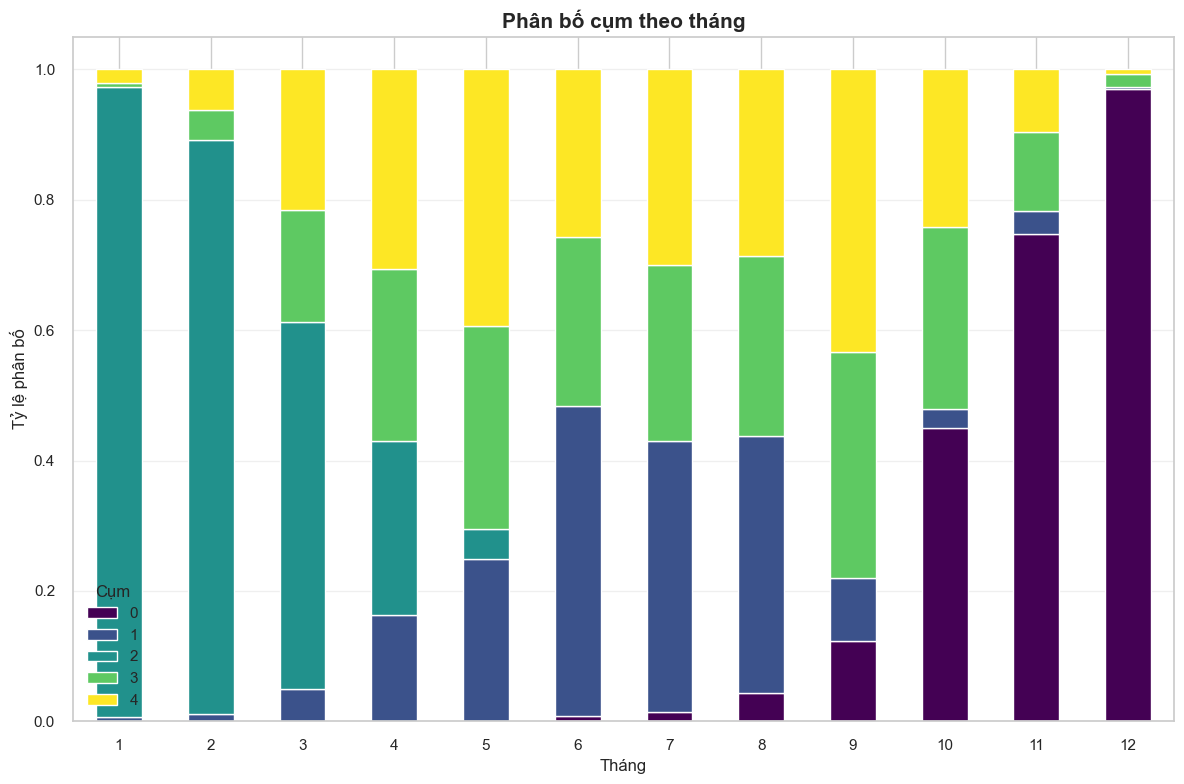

In [ ]:
# Phân tích phân bố cụm theo tháng
plt.figure(figsize=(14, 8))

monthly_cluster = pd.crosstab(df["month"], df["cluster"])

monthly_cluster_pct = monthly_cluster.div(monthly_cluster.sum(axis=1), axis=0)
monthly_cluster_pct.plot(kind="bar", stacked=True, colormap="viridis")

plt.title("Phân bố cụm theo tháng", fontsize=15, fontweight="bold")
plt.xlabel("Tháng", fontsize=12)
plt.ylabel("Tỷ lệ phân bố", fontsize=12)
plt.xticks(rotation=0) 
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Cụm")
plt.tight_layout()
plt.show()

In [ ]:
cluster_summary = (
    df.groupby("cluster")
    .agg(
        {
            "temperature": "mean",
            "humidity": "mean",
            "wind_speed": "mean",
            "pressure": "mean",
            "visibility": "mean",
            "hour": "mean",
        }
    )
    .round(2)
)
weather_distribution = pd.crosstab(
    df["cluster"], df["weather"], normalize="index"
).round(2)
cluster_summary = pd.concat([cluster_summary, weather_distribution], axis=1)
print("Bảng tổng hợp đặc điểm của từng cụm:")
display(cluster_summary)

Bảng tổng hợp đặc điểm của từng cụm:


temperature  humidity  wind_speed  pressure  visibility   hour  \
cluster                                                                   
0              26.32     86.24        4.05   1007.76        8.05   3.47   
1              24.10     84.37        9.51   1014.81        7.07  12.02   
2              32.03     61.34       11.86   1006.70        8.59  12.53   
3              27.59     81.49        6.23   1008.17        8.18  19.87   
4              22.90     80.68        7.63   1016.48        7.39  11.23   

         Clear  Cloudy   Fog  Rain  Thunderstorms  
cluster                                            
0         0.09    0.83  0.02  0.06           0.00  
1         0.07    0.55  0.01  0.36           0.01  
2         0.10    0.88  0.00  0.01           0.01  
3         0.04    0.88  0.00  0.06           0.02  
4         0.11    0.75  0.05  0.09           0.00

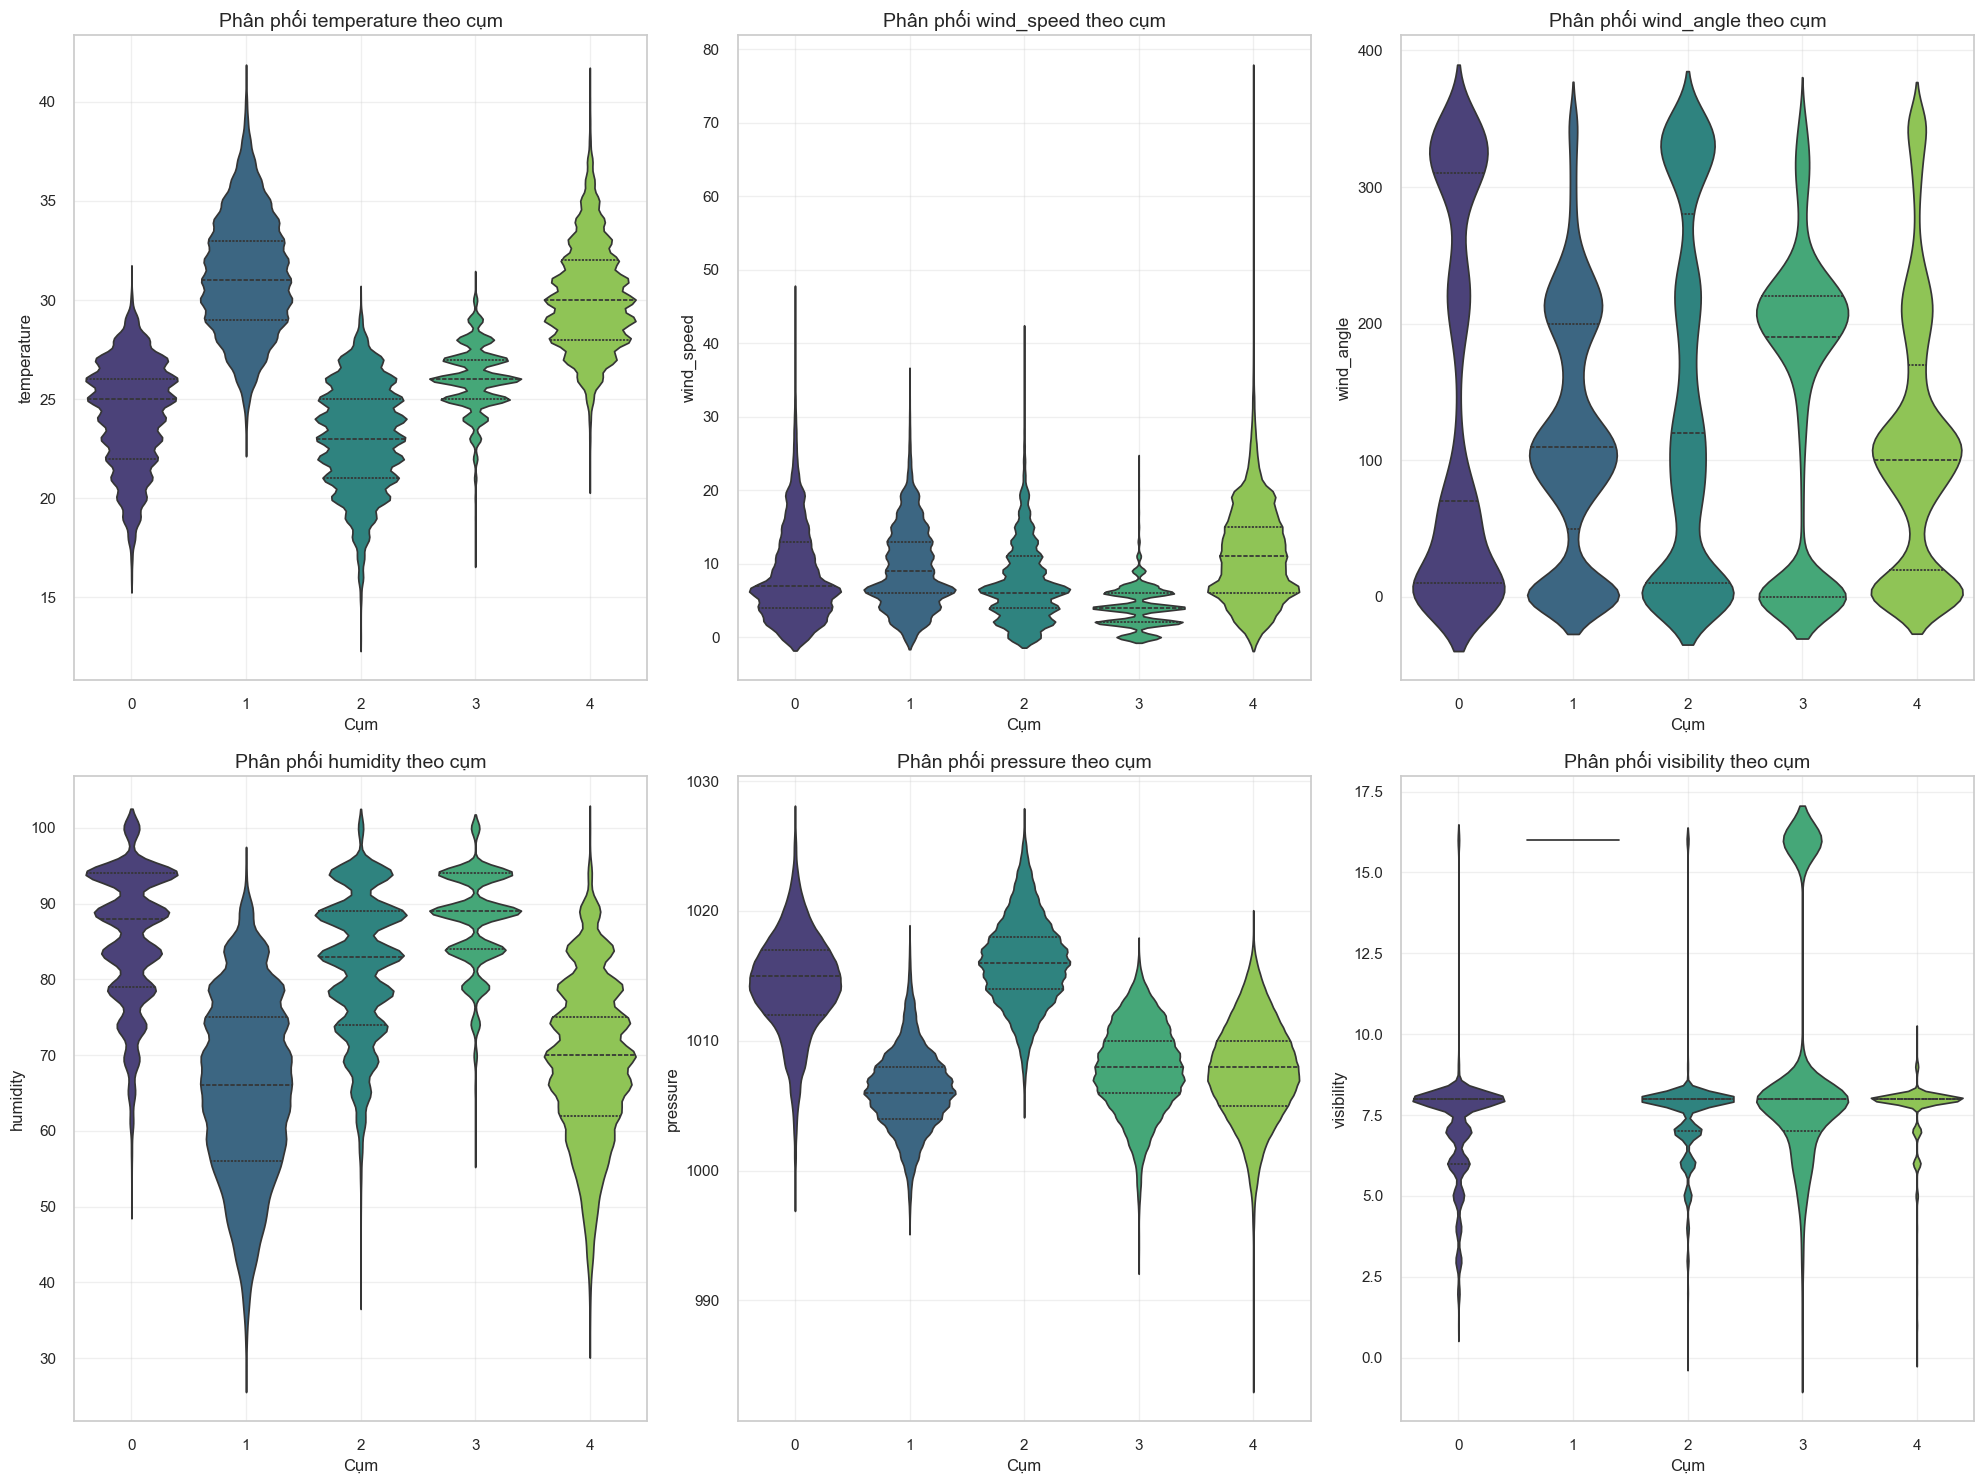

In [ ]:
plt.figure(figsize=(20, 15))
numeric_cols = [
    "temperature",
    "wind_speed",
    "wind_angle",
    "humidity",
    "pressure",
    "visibility",
]

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(x="cluster", y=col, data=df, palette="viridis", inner="quartile")
    plt.title(f"Phân phối {col} theo cụm", fontsize=14)
    plt.xlabel("Cụm", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**NHẬN XÉT:**
1. Temperature (Nhiệt độ)
   - Cụm 0: 
   - Cụm 1: 
   - Cụm 2: 
   - Cụm 3: 
   - Cụm 4:
2. Wind Speed (Tốc độ gió)
   - Cụm 0: 
   - Cụm 1: 
   - Cụm 2: 
   - Cụm 3: 
   - Cụm 4:
3. Wind Angle (Góc gió)
   - Cụm 0: 
   - Cụm 1: 
   - Cụm 2: 
   - Cụm 3: 
   - Cụm 4:
4. Humidity (Độ ẩm)
   - Cụm 0: 
   - Cụm 1: 
   - Cụm 2: 
   - Cụm 3: 
   - Cụm 4:
5. Pressure (Áp suất)
   - Cụm 0: 
   - Cụm 1: 
   - Cụm 2: 
   - Cụm 3: 
   - Cụm 4:
6. Visibility (Tầm nhìn)
   - Cụm 0: 
   - Cụm 1: 
   - Cụm 2: 
   - Cụm 3: 
   - Cụm 4:

____

#### B. Mô hình Gaussian Mixture Model (GMM)

##### 1. Cơ sở lý thuyết:
 GMM là mô hình xác suất giả định rằng tất cả các điểm dữ liệu được sinh ra từ hỗn hợp của một số hữu hạn các phân phối Gaussian với các tham số khác nhau. Mỗi phân phối Gaussian đại diện cho một cụm. Thuật toán EM (Expectation-Maximization) được sử dụng để ước tính các tham số của mô hình.
##### 2. Siêu tham số chính:
- n_components: Số lượng phân phối Gaussian (cụm)
- covariance_type: Loại ma trận hiệp phương sai ('full', 'tied', 'diag', 'spherical')
- n_init: Số lần chạy thuật toán với các khởi tạo khác nhau

##### 3. Lựa chọn siêu tham số cho mô hình

In [18]:
# Các tham số cần tối ưu
n_components_range = range(2,10)  # Số lượng cụm
covariance_types = ["full", "tied"]  # Loại ma trận hiệp phương sai
# covariance_types = ["full", "tied", "diag", "spherical"]

results = []

for n_components in n_components_range:
    for cov_type in covariance_types:
        try:
            # Áp dụng GMM
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=cov_type,
                random_state=42,
                n_init=5,  # Giảm xuống tăng tốc độ thực thi
            )
           
            gmm.fit(df_pca)
            labels = gmm.predict(df_pca)
            # Tính các chỉ số đánh giá
            if len(np.unique(labels)) > 1:  
                # sil_score = silhouette_score(df_pca, labels)
                # db_score = davies_bouldin_score(df_pca, labels)
                # ch_score = calinski_harabasz_score(df_pca, labels)
                bic_score = gmm.bic(df_pca)  
                aic_score = gmm.aic(df_pca)  
                results.append(
                    {
                        "n_components": n_components,
                        "covariance_type": cov_type,
                        # "silhouette": sil_score,
                        # "davies_bouldin": db_score,
                        # "calinski_harabasz": ch_score,
                        "bic": bic_score,
                        "aic": aic_score,
                    }
                )
                print(
                    f"n_components={n_components}, covariance_type={cov_type}: "
                    # f"silhouette={sil_score:.3f}, davies_bouldin={db_score:.3f}, "
                    # f"calinski_harabasz={ch_score:.1f},"
                    f"BIC={bic_score:.1f}, AIC={aic_score:.1f}"
                )
        except Exception as e:
            print(
                f"Lỗi với n_components={n_components}, covariance_type={cov_type}: {str(e)}"
            )

n_components=2, covariance_type=full: BIC=1608915.5, AIC=1608249.4
n_components=2, covariance_type=tied: BIC=1603911.4, AIC=1603508.0
n_components=3, covariance_type=full: BIC=1545925.3, AIC=1544921.5
n_components=3, covariance_type=tied: BIC=1581839.1, AIC=1581360.6
n_components=4, covariance_type=full: BIC=1185665.7, AIC=1184324.1
n_components=4, covariance_type=tied: BIC=1525389.3, AIC=1524835.7
n_components=5, covariance_type=full: BIC=1146789.8, AIC=1145110.4
n_components=5, covariance_type=tied: BIC=1510712.1, AIC=1510083.6
n_components=6, covariance_type=full: BIC=1108804.7, AIC=1106787.6
n_components=6, covariance_type=tied: BIC=1505921.6, AIC=1505218.0
n_components=7, covariance_type=full: BIC=1079943.9, AIC=1077589.0
n_components=7, covariance_type=tied: BIC=1487055.2, AIC=1486276.5
n_components=8, covariance_type=full: BIC=1078634.7, AIC=1075942.1
n_components=8, covariance_type=tied: BIC=1476747.5, AIC=1475893.7
n_components=9, covariance_type=full: BIC=1036378.4, AIC=10333

Trực quan hóa kết quả tìm siêu tham số

In [19]:
results_df = pd.DataFrame(results)

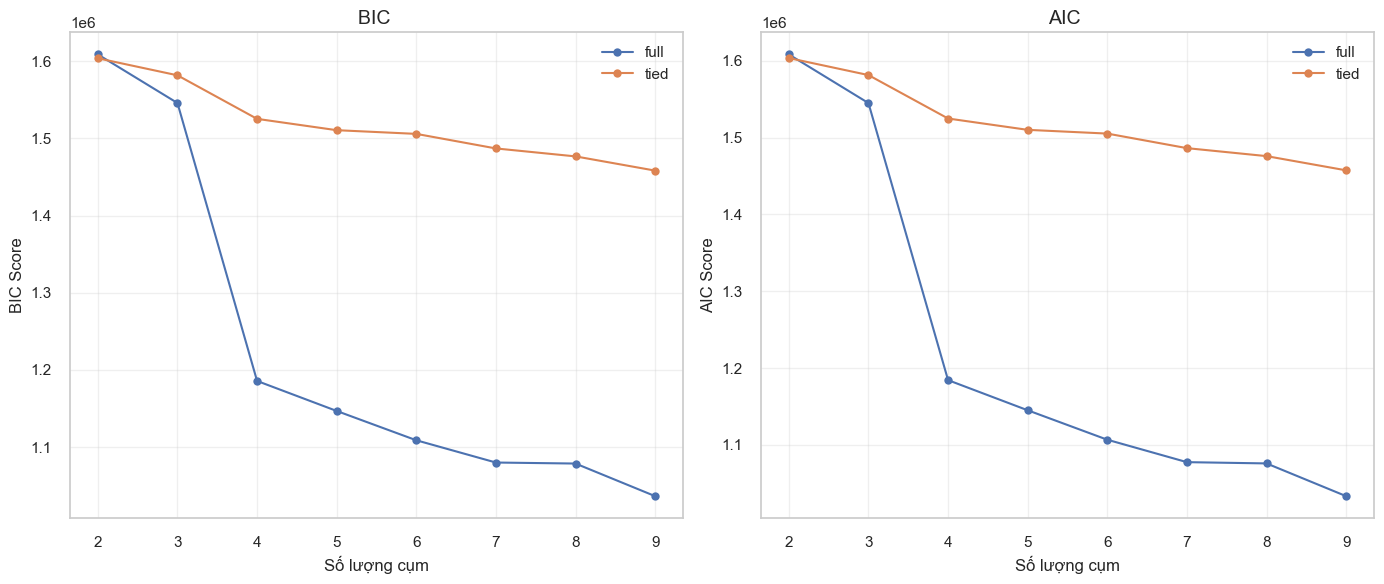

In [ ]:
plt.figure(figsize=(14, 6))

# 1. BIC (Bayesian Information Criterion)
plt.subplot(1, 2, 1)
for cov_type in covariance_types:
    cov_data = results_df[results_df["covariance_type"] == cov_type]
    if not cov_data.empty:
        plt.plot(cov_data["n_components"], cov_data["bic"], marker="o", label=cov_type)
plt.title("BIC ", fontsize=14)
plt.xlabel("Số lượng cụm", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# 2. AIC (Akaike Information Criterion)
plt.subplot(1, 2, 2)
for cov_type in covariance_types:
    cov_data = results_df[results_df["covariance_type"] == cov_type]
    if not cov_data.empty:
        plt.plot(cov_data["n_components"], cov_data["aic"], marker="o", label=cov_type)
plt.title("AIC ", fontsize=14)
plt.xlabel("Số lượng cụm", fontsize=12)
plt.ylabel("AIC Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Quyết định bộ tham số cho mô hình:
- n_components = 4
- covariance_type = "full"

##### 4. Huấn luyện GMM

In [ ]:
optimal_n_components = 7
optimal_cov_type = "full"

gmm = GaussianMixture(
    n_components=optimal_n_components,
    covariance_type=optimal_cov_type,
    random_state=42,
    n_init=10,
)
gmm.fit(df_pca)
df["gmm_cluster"] = gmm.predict(df_pca)

In [26]:
import pickle
import joblib
from pathlib import Path

Path("models").mkdir(exist_ok=True)
with open("models/gmm_model.pkl", "wb") as f:
    pickle.dump(gmm, f)

##### 5. Trực quan hóa kết quả GMM
*Phân phối số lượng mẫu trong từng cụm

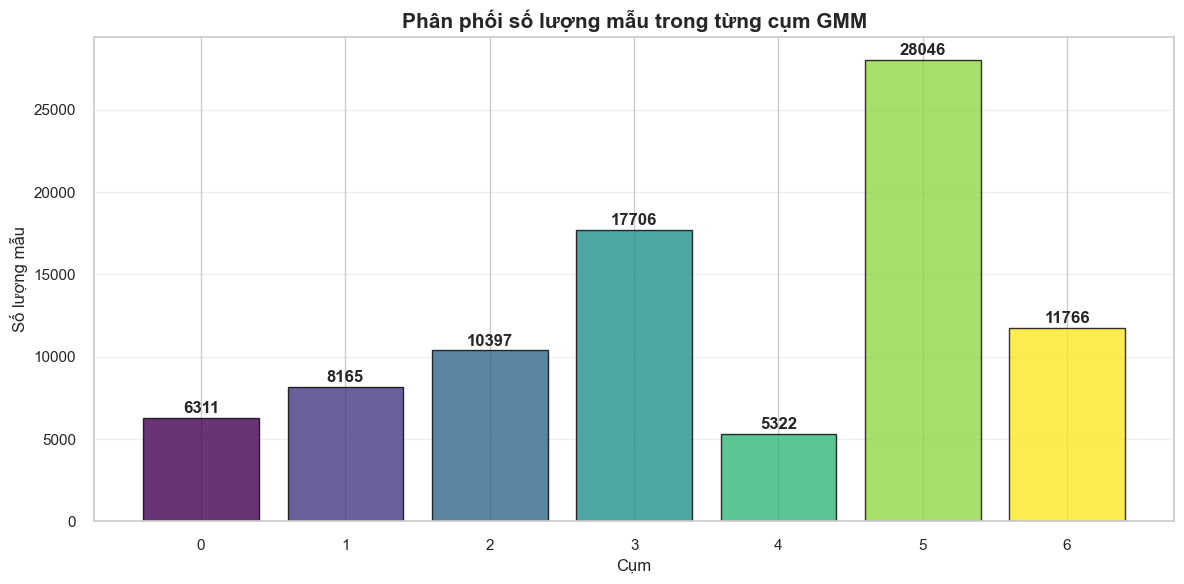

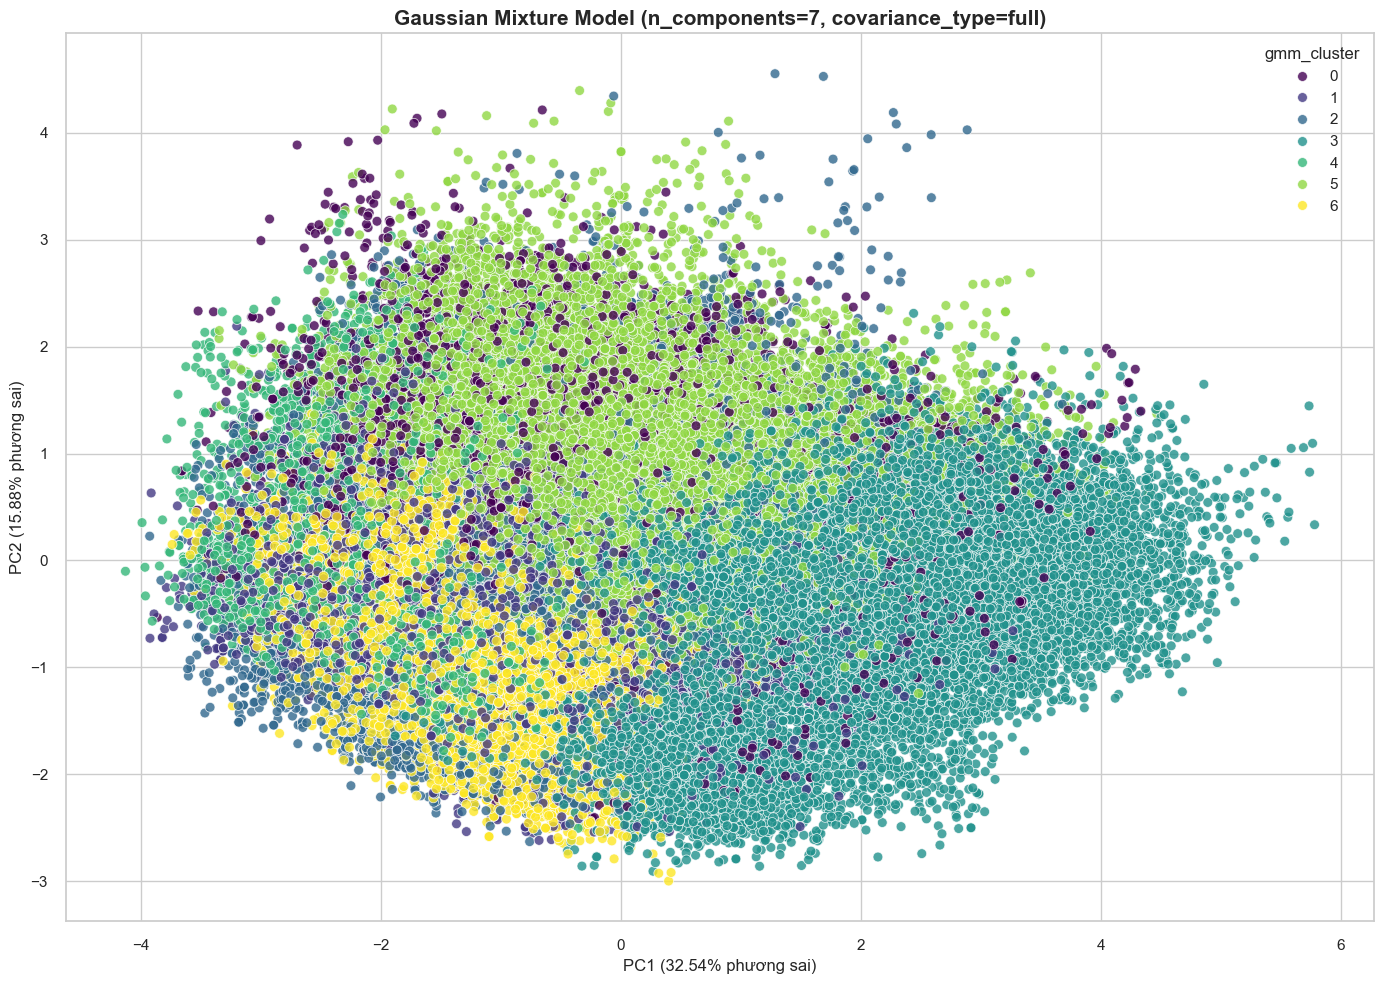

In [ ]:
# Biểu đồ phân phối số lượng mẫu trong từng cụm
plt.figure(figsize=(12, 6))
gmm_cluster_counts = df["gmm_cluster"].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, optimal_n_components))

bars = plt.bar(
    gmm_cluster_counts.index,
    gmm_cluster_counts.values,
    color=colors,
    alpha=0.8,
    edgecolor="black",
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 100,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )
plt.title(f"Phân phối số lượng mẫu trong từng cụm GMM", fontsize=15, fontweight="bold")
plt.xlabel("Cụm", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(range(optimal_n_components))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Biểu đồ phân cụm trên không gian PCA
plt.figure(figsize=(14, 10))

sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="gmm_cluster",
    data=pd.concat([df_pca, df[["gmm_cluster"]]], axis=1),
    palette="viridis",
    alpha=0.8,
    s=50,
)
plt.title(
    f"Gaussian Mixture Model (n_components={optimal_n_components}, covariance_type={optimal_cov_type})",
    fontsize=15,
    fontweight="bold",
)
plt.xlabel(f"PC1 ({explained_variance[0]:.2%} phương sai)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2%} phương sai)", fontsize=12)
plt.tight_layout()
plt.show()

##### 6. Phân tích đặc điểm cụm và áp dụng domain knowledge

<Figure size 1400x800 with 0 Axes>

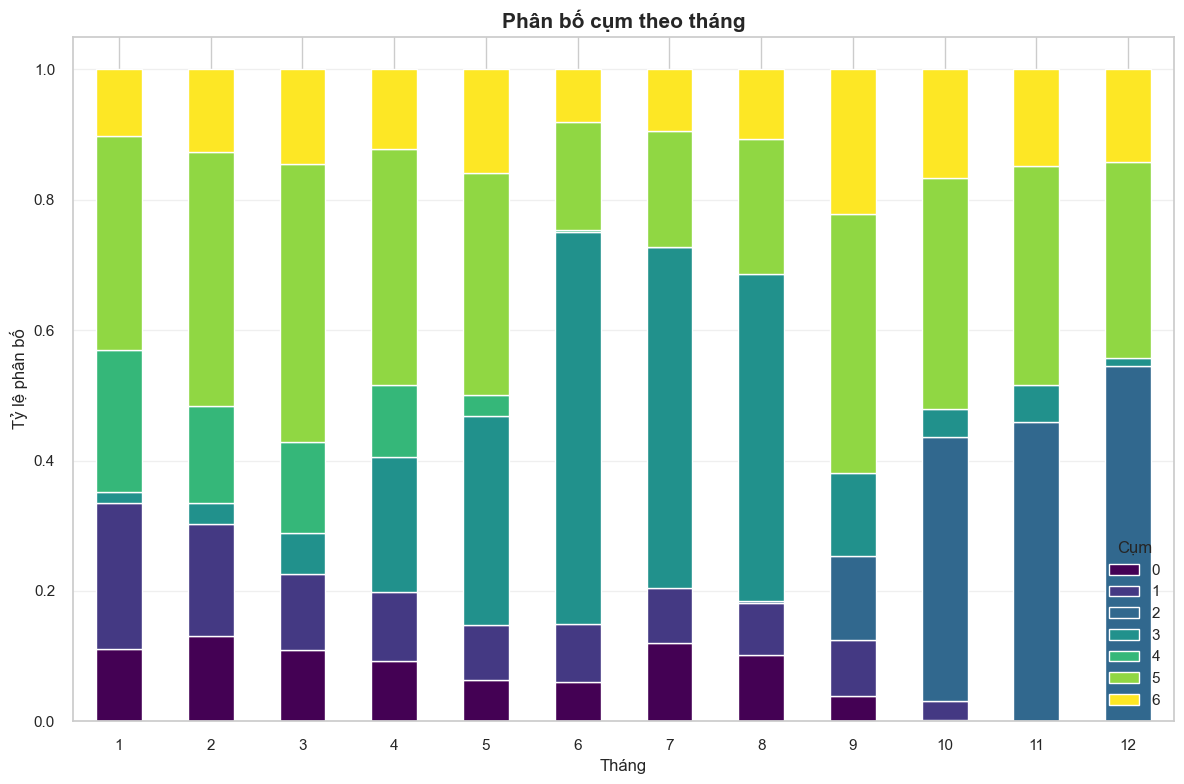

In [ ]:
# Phân tích phân bố cụm theo tháng
plt.figure(figsize=(14, 8))

monthly_cluster = pd.crosstab(df["month"], df["gmm_cluster"])

monthly_cluster_pct = monthly_cluster.div(monthly_cluster.sum(axis=1), axis=0)
monthly_cluster_pct.plot(kind="bar", stacked=True, colormap="viridis")

plt.title("Phân bố cụm theo tháng", fontsize=15, fontweight="bold")
plt.xlabel("Tháng", fontsize=12)
plt.ylabel("Tỷ lệ phân bố", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Cụm")
plt.tight_layout()
plt.show()

In [ ]:
cluster_summary = (
    df.groupby("gmm_cluster")
    .agg(
        {
            "temperature": "mean",
            "humidity": "mean",
            "wind_speed": "mean",
            "pressure": "mean",
            "visibility": "mean",
            "hour": "mean",
        }
    )
    .round(2)
)
weather_distribution = pd.crosstab(
    df["gmm_cluster"], df["weather"], normalize="index"
).round(2)
cluster_summary = pd.concat([cluster_summary, weather_distribution], axis=1)
print("Bảng tổng hợp đặc điểm của từng cụm:")
display(cluster_summary)

Bảng tổng hợp đặc điểm của từng cụm:


temperature  humidity  wind_speed  pressure  visibility   hour  \
gmm_cluster                                                                   
0                  26.82     77.40       10.50   1010.86        6.53  12.60   
1                  25.37     80.61        1.94   1011.80        7.13   9.86   
2                  24.15     86.82       10.06   1013.14        6.11  10.88   
3                  30.13     70.00        8.21   1006.57       16.00  11.84   
4                  22.40     87.73        5.30   1014.42        6.29   7.71   
5                  27.40     74.12       10.52   1011.55        8.00  15.99   
6                  24.70     86.58        4.53   1011.08        8.00   3.52   

             Clear  Cloudy   Fog  Rain  Thunderstorms  
gmm_cluster                                            
0             0.07    0.77  0.01  0.13           0.02  
1             0.09    0.76  0.05  0.08           0.01  
2             0.04    0.44  0.01  0.48           0.02  
3             0.13    0.87  0.00  0.00           0.00  
4             0.05    0.68  0.15  0.12           0.00  
5             0.09    0.85  0.00  0.05           0.01  
6             0.06    0.88  0.00  0.06           0.00

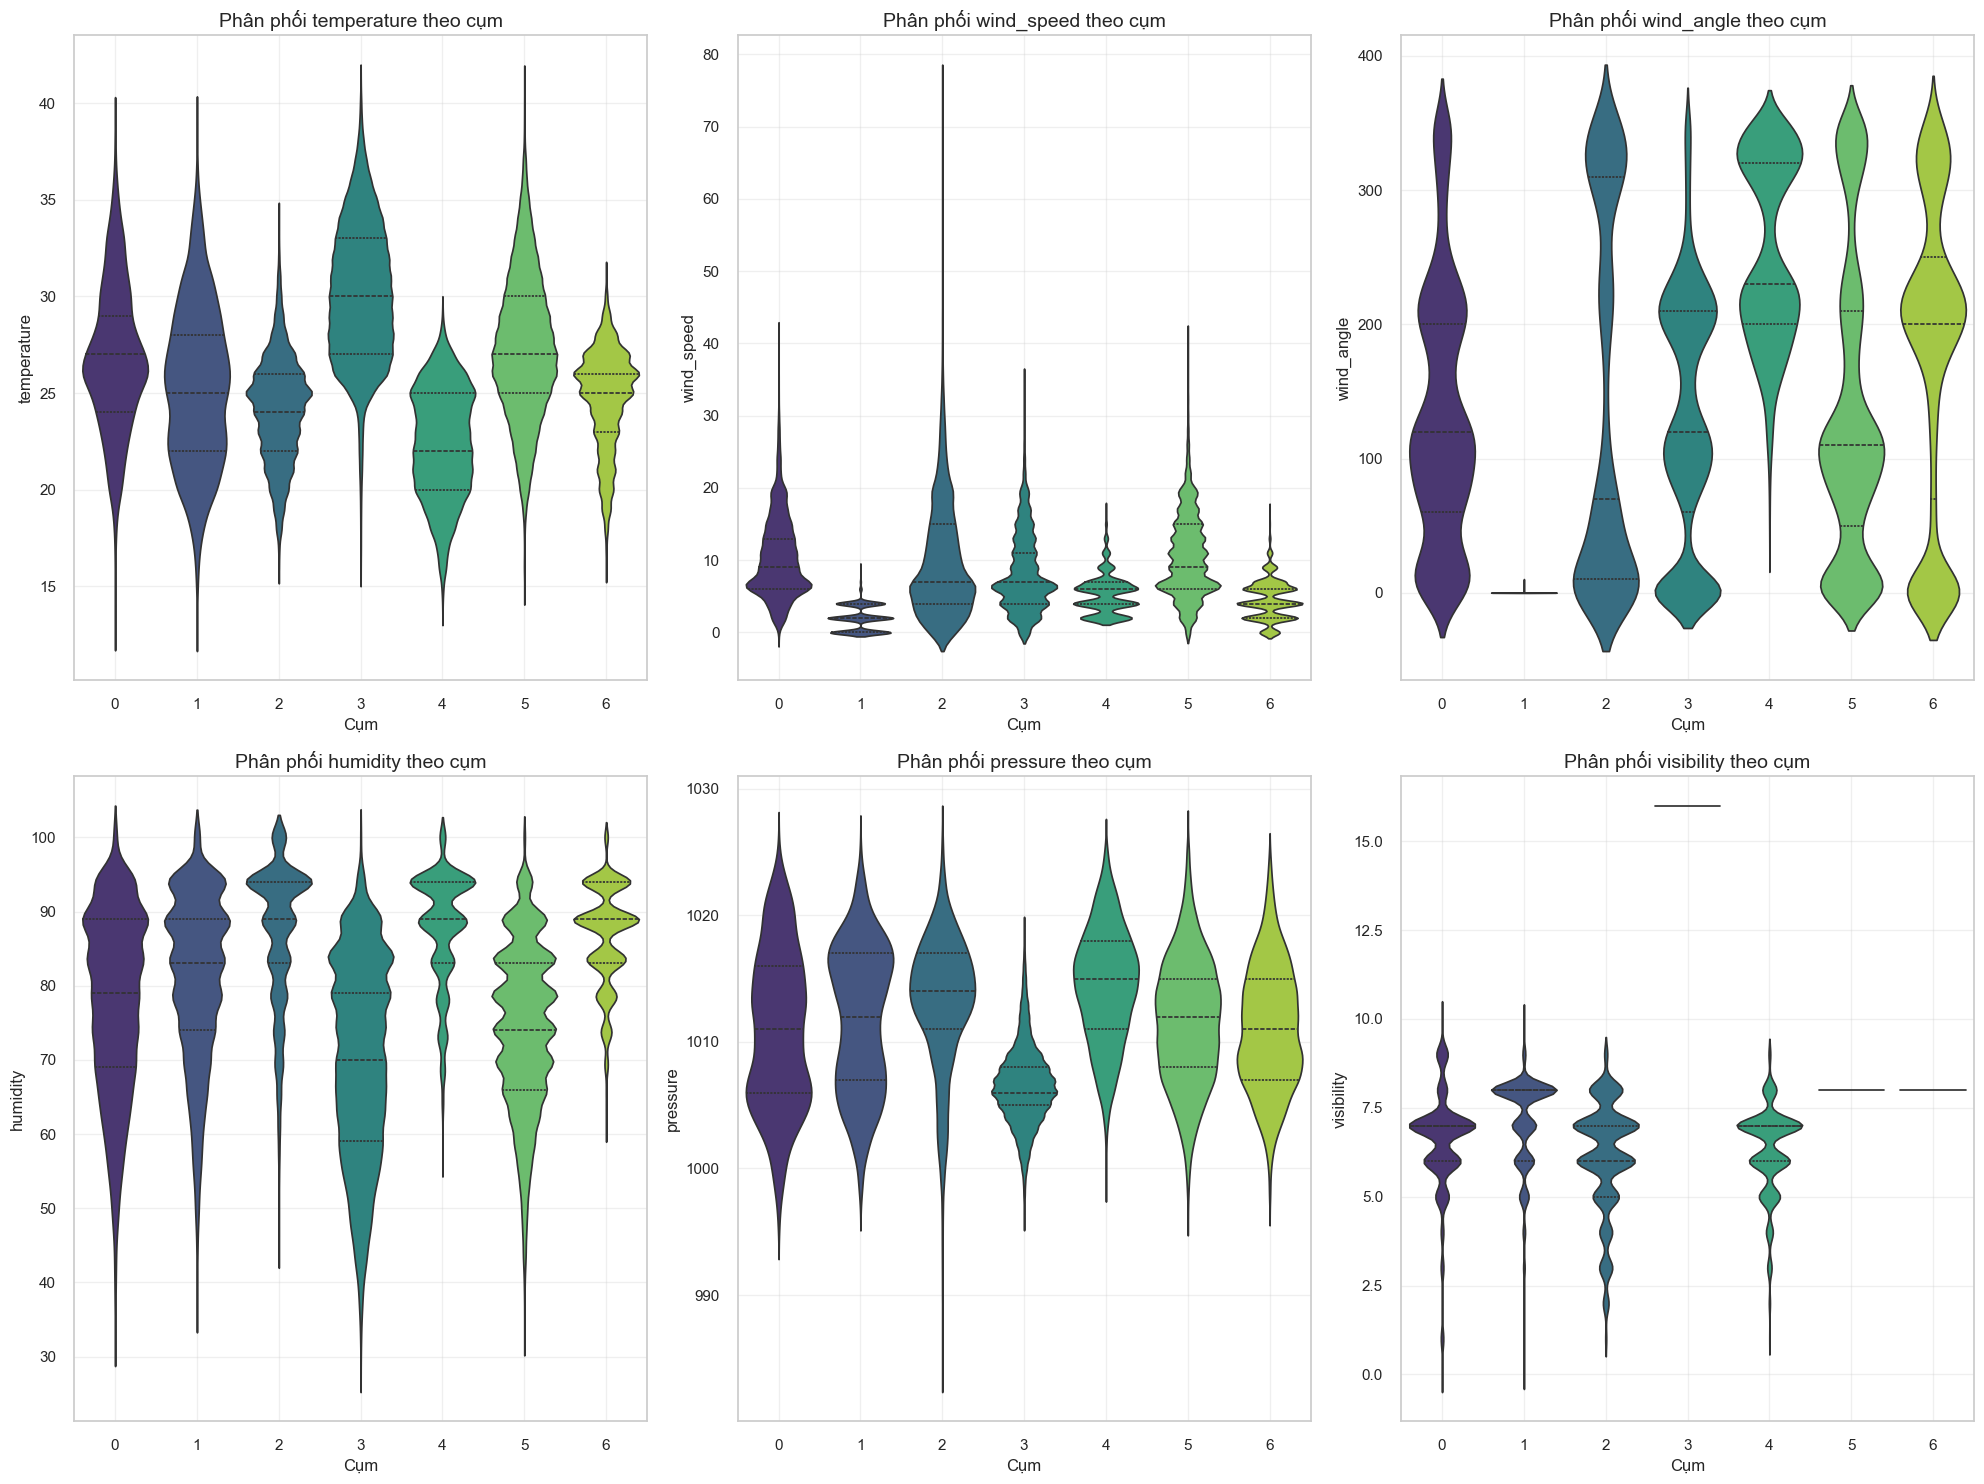

In [53]:
plt.figure(figsize=(20, 15))
numeric_cols = [
    "temperature",
    "wind_speed",
    "wind_angle",
    "humidity",
    "pressure",
    "visibility",
]

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(x="gmm_cluster", y=col, data=df, palette="viridis", inner="quartile")
    plt.title(f"Phân phối {col} theo cụm", fontsize=14)
    plt.xlabel("Cụm", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### C. Kết luận và đánh giá tổng thể

In [55]:
kmeans_labels = df["cluster"]
gmm_labels = df["gmm_cluster"]

kmeans_silhouette = silhouette_score(df_pca, kmeans_labels)
gmm_silhouette = silhouette_score(df_pca, gmm_labels)

kmeans_db = davies_bouldin_score(df_pca, kmeans_labels)
gmm_db = davies_bouldin_score(df_pca, gmm_labels)
comparison_df = pd.DataFrame(
    {
        "K-means": [
            int(optimal_k),
            round(kmeans_silhouette, 3),
            round(kmeans_db, 3),
        ],
        "GMM": [
            int(optimal_n_components),
            round(gmm_silhouette, 3),
            round(gmm_db, 3),
        ],
    },
    index=[
        "Số cụm",
        "Silhouette Score ",
        "Davies-Bouldin Index ",
    ],
)
print("\nChỉ số đánh giá giữa K-means và GMM")
display(comparison_df)


Chỉ số đánh giá giữa K-means và GMM


K-means    GMM
Số cụm                   5.000  7.000
Silhouette Score         0.194  0.068
Davies-Bouldin Index     1.617  2.998

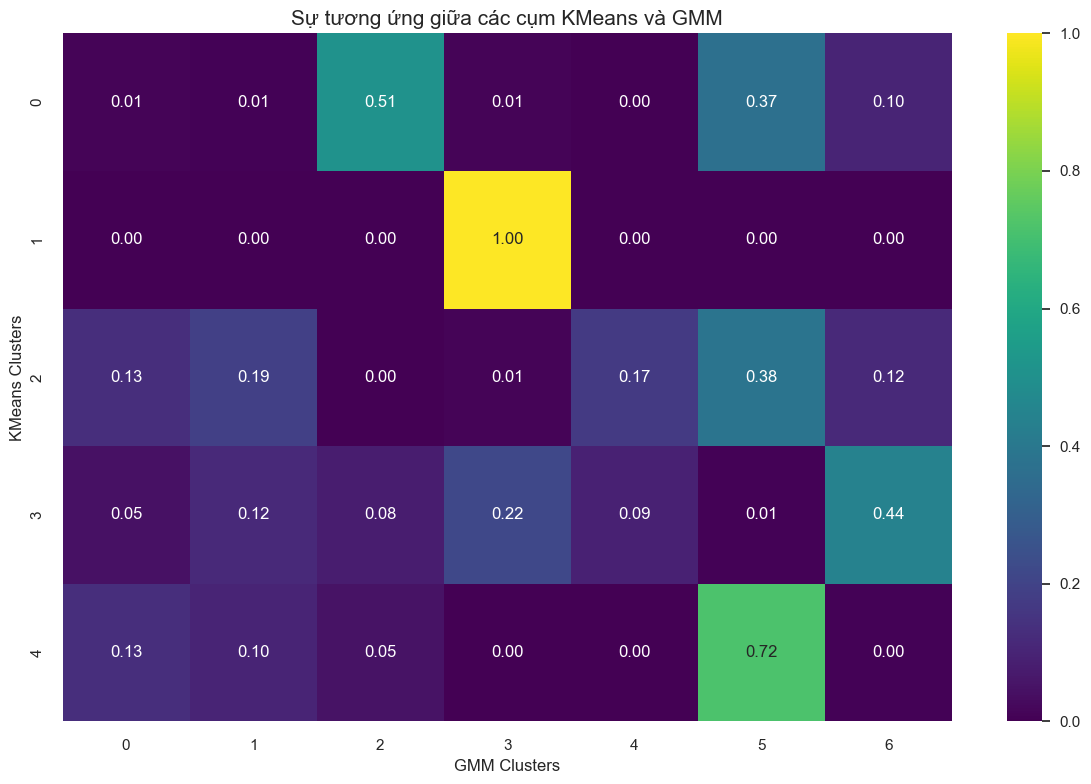

In [56]:
# So sánh sự tương ứng giữa các cụm từ hai phương pháp
cross_clusters = pd.crosstab(df["cluster"], df["gmm_cluster"])
cross_clusters_pct = cross_clusters.div(cross_clusters.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(cross_clusters_pct, annot=True, cmap="viridis", fmt=".2f")
plt.title("Sự tương ứng giữa các cụm KMeans và GMM", fontsize=15)
plt.xlabel("GMM Clusters", fontsize=12)
plt.ylabel("KMeans Clusters", fontsize=12)
plt.tight_layout()
plt.show()

***Phân tích sự tương ứng giữa các cụm:***


***Ý nghĩa về mặt phân nhóm dữ liệu:***
  